# Training step

In [1]:
%cd GAS

/notebooks/AISIA-hotel


/root/anaconda3/envs/newpy/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Training

In [18]:
!python main.py --task tasd \
            --dataset new_Data \
            --model_name_or_path t5-base \
            --paradigm extraction \
            --n_gpu 0 \
            --do_train \
            --do_direct_eval \
            --train_batch_size 16 \
            --gradient_accumulation_steps 2 \
            --eval_batch_size 16 \
            --learning_rate 3e-4 \
            --num_train_epochs 20


 ============================== NEW EXP: TASD on new_Data ============================== 

Seed set to 42
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Here is an example (from dev set) under `extraction` paradigm:
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:

In [ ]:
import shutil
shutil.make_archive('/content/drive/MyDrive/TASD/MyProj/AISIA-hotel/outputs/output_new', 'zip', '/content/drive/MyDrive/TASD/MyProj/AISIA-hotel/outputs/tasd/new_Data/extraction')

'/content/drive/MyDrive/TASD/MyProj/AISIA-hotel/outputs/output_new.zip'

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/TASD/MyProj/AISIA-hotel/outputs/output_new.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test step

In [3]:
# File data_utils.py
import time
from torch.utils.data import Dataset

senttag2word = {'POS': 'positive', 'NEG': 'negative', 'NEU': 'neutral'}


def read_line_examples_from_file(data_path, silence=False):
    """
    Read data from file, each line is: sent####labels
    Return List[List[word]], List[Tuple]
    """
    id_users, sents, labels = [], [], []
    with open(data_path, "r", encoding="UTF-8") as fp:
        words, labels = [], []
        for line in fp:
            line = line.strip()
            if line != "":
                words, tuples = line.split("####")
                if tuples != "":
                    labels.append(eval(tuples))
                else:
                    words = line
                # Get id user at the beginning of line if it exist
                words = words.split()
                if len(words[0].split(',', 1)) > 1:
                    id_user, word = words[0].split(',',1)
                    words[0] = word
                    id_users.append(int(id_user))
                sents.append(words)

    if silence:
        print(f"Total examples = {len(sents)}")
    return id_users, sents, labels

# Khong quan tam
def get_annotated_uabsa_targets(sents, labels):
    annotated_targets = []
    num_sents = len(sents)
    for i in range(num_sents):
        tuples = labels[i]
        if tuples != []:
            # tup: ([3, 4], POS)
            for tup in tuples:
                ap, sent = tup[0], tup[1]
                if len(ap) == 1:
                    sents[i][ap[0]] = f"[{sents[i][ap[0]]}|{senttag2word[sent]}]"
                else:
                    sents[i][ap[0]] = f"[{sents[i][ap[0]]}"
                    sents[i][ap[-1]] = f"{sents[i][ap[-1]]}|{senttag2word[sent]}]"
        annotated_targets.append(sents[i])

    return annotated_targets

# Khong quan tam
def get_annotated_aope_targets(sents, labels):
    annotated_targets = []
    num_sents = len(sents)
    for i in range(num_sents):
        tuples = labels[i]
        # tup: ([3, 4], [2])
        for tup in tuples:
            ap, op = tup[0], tup[1]
            opt = [sents[i][j] for j in op]
            # multiple OT for one AP
            if '[' in sents[i][ap[0]]:
                if len(ap) == 1:
                    sents[i][ap[0]] = f"{sents[i][ap[0]][:-1]}, {' '.join(opt)}]"
                else:
                    sents[i][ap[-1]] = f"{sents[i][ap[-1]][:-1]}, {' '.join(opt)}]"
            else:
                annotation = f"{' '.join(opt)}"
                if len(ap) == 1:
                    sents[i][ap[0]] = f"[{sents[i][ap[0]]}|{annotation}]"
                else:
                    sents[i][ap[0]] = f"[{sents[i][ap[0]]}"
                    sents[i][ap[-1]] = f"{sents[i][ap[-1]]}|{annotation}]"
        annotated_targets.append(sents[i])

    return annotated_targets

# Khong quan tam
def get_annotated_aste_targets(sents, labels):

    annotated_targets = []
    num_sents = len(sents)
    for i in range(num_sents):
        tuples = labels[i]
        # tup: ([2], [5], 'NEG')
        for tup in tuples:
            ap, op, sent = tup[0], tup[1], tup[2]
            op = [sents[i][j] for j in op]
            # multiple OT for one AP
            if '[' in sents[i][ap[0]]:
                # print(i)
                if len(ap) == 1:
                    sents[i][ap[0]] = f"{sents[i][ap[0]][:-1]}, {' '.join(op)}]"
                else:
                    sents[i][ap[-1]] = f"{sents[i][ap[-1]][:-1]}, {' '.join(op)}]"
            else:
                annotation = f"{senttag2word[sent]}|{' '.join(op)}"
                if len(ap) == 1:
                    sents[i][ap[0]] = f"[{sents[i][ap[0]]}|{annotation}]"
                else:
                    sents[i][ap[0]] = f"[{sents[i][ap[0]]}"
                    sents[i][ap[-1]] = f"{sents[i][ap[-1]]}|{annotation}]"
        annotated_targets.append(sents[i])
    return annotated_targets

# Khong quan tam
def get_annotated_tasd_targets(sents, labels):
    targets = []
    num_sents = len(sents)
    sents_str = [' '.join(s) for s in sents]
    for i in range(num_sents):
        s_str = sents_str[i]
        at_dict = {}
        for triplet in labels[i]:
            at, ac, polarity = triplet[0], triplet[1], triplet[2]
            if at in at_dict:
                at_dict[at][0].append(ac)
            else:
                at_dict[at] = [[ac], polarity]
        for at, ac_pol in at_dict.items():
            if len(ac_pol[0]) == 1:
                annotated_at = f"[{at}|{ac_pol[0][0]}|{ac_pol[1]}]"
            else:
                annotated_at = f"[{at}|{', '.join(ac_pol[0])}|{ac_pol[1]}]"
            if at != 'NULL':
                # print('at:', at, 'replaced_at:', annotated_at)
                s_str = s_str.replace(at, annotated_at)
            else:
                s_str += f" {annotated_at}"
        targets.append(s_str)
    return targets


# Khong quan tam
def get_extraction_uabsa_targets(sents, labels):
    targets = []
    for i, label in enumerate(labels):
        if label == []:
            targets.append('None')
        else:
            all_tri = []
            for tri in label:
                if len(tri[0]) == 1:
                    a = sents[i][tri[0][0]]
                else:
                    start_idx, end_idx = tri[0][0], tri[0][-1]
                    a = ' '.join(sents[i][start_idx:end_idx+1])
                c = senttag2word[tri[1]]
                all_tri.append((a, c))
            label_strs = ['('+', '.join(l)+')' for l in all_tri]
            targets.append('; '.join(label_strs))
    return targets



# Khong quan tam
def get_extraction_aope_targets(sents, labels):
    targets = []
    for i, label in enumerate(labels):
        all_tri = []
        for tri in label:
            if len(tri[0]) == 1:
                a = sents[i][tri[0][0]]
            else:
                start_idx, end_idx = tri[0][0], tri[0][-1]
                a = ' '.join(sents[i][start_idx:end_idx+1])
            if len(tri[1]) == 1:
                b = sents[i][tri[1][0]]
            else:
                start_idx, end_idx = tri[1][0], tri[1][-1]
                b = ' '.join(sents[i][start_idx:end_idx+1])
            all_tri.append((a, b))
        label_strs = ['('+', '.join(l)+')' for l in all_tri]
        targets.append('; '.join(label_strs))
    return targets


def get_extraction_tasd_targets(sents, labels):
    targets = []
    for label in labels:
        label_strs = ['('+', '.join(l)+')' for l in label]
        target = '; '.join(label_strs)
        targets.append(target)
    return targets


# Khong quan tam
def get_extraction_aste_targets(sents, labels):
    targets = []
    for i, label in enumerate(labels):
        all_tri = []
        for tri in label:
            if len(tri[0]) == 1:
                a = sents[i][tri[0][0]]
            else:
                start_idx, end_idx = tri[0][0], tri[0][-1]
                a = ' '.join(sents[i][start_idx:end_idx+1])
            if len(tri[1]) == 1:
                b = sents[i][tri[1][0]]
            else:
                start_idx, end_idx = tri[1][0], tri[1][-1]
                b = ' '.join(sents[i][start_idx:end_idx+1])
            c = senttag2word[tri[2]]
            all_tri.append((a, b, c))
        label_strs = ['('+', '.join(l)+')' for l in all_tri]
        targets.append('; '.join(label_strs))
    return targets


def get_transformed_io(data_path, paradigm, task):
    """
    The main function to transform the Input & Output according to
    the specified paradigm and task
    """
    id_users, sents, labels = read_line_examples_from_file(data_path)

    # the input is just the raw sentence
    inputs = [s.copy() for s in sents]

    # Get target according to the paradigm
    # annotate the sents (with label info) as targets
    if paradigm == 'annotation':
        if task == 'uabsa':
            targets = get_annotated_uabsa_targets(sents, labels)
        elif task == 'aste':
            targets = get_annotated_aste_targets(sents, labels)
        elif task == 'tasd':
            targets = get_annotated_tasd_targets(sents, labels)
        elif task == 'aope':
            targets = get_annotated_aope_targets(sents, labels)
        else:
            raise NotImplementedError
    # directly treat label infor as the target
    elif paradigm == 'extraction':
        if task == 'uabsa':
            targets = get_extraction_uabsa_targets(sents, labels)
        elif task == 'aste':
            targets = get_extraction_aste_targets(sents, labels)
        elif task == 'tasd':
            targets = get_extraction_tasd_targets(sents, labels)
        elif task == 'aope':
            targets = get_extraction_aope_targets(sents, labels)
        else:
            raise NotImplementedError
    else:
        print('Unsupported paradigm!')
        raise NotImplementedError

    return id_users, inputs, targets


class ABSADataset(Dataset):
    def __init__(self, tokenizer, data_dir, data_type, paradigm, task, max_len=128):
        # 'data/aste/rest16/train.txt'
        self.data_path = f'data/{task}/{data_dir}/{data_type}.txt'
        self.paradigm = paradigm
        self.task = task
        self.max_len = max_len
        self.tokenizer = tokenizer

        self.inputs = []
        self.targets = []
        self.id_users = []

        self._build_examples()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()      # might need to squeeze
        target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

        return {"source_ids": source_ids, "source_mask": src_mask,
                "target_ids": target_ids, "target_mask": target_mask}

    def _build_examples(self):

        id_users, inputs, targets = get_transformed_io(self.data_path, self.paradigm, self.task)

        self.id_users = id_users

        for i in range(len(inputs)):

            input = ' '.join(inputs[i])
            if self.paradigm == 'annotation':
                if self.task != 'tasd':
                    target = ' '.join(targets[i])
                else:
                    target = targets[i]
            else:
                target = targets[i]

            tokenized_input = self.tokenizer.batch_encode_plus(
              [input], max_length=self.max_len, pad_to_max_length=True, truncation=True,
              return_tensors="pt",
            )
            tokenized_target = self.tokenizer.batch_encode_plus(
              [target], max_length=self.max_len, pad_to_max_length=True, truncation=True,
              return_tensors="pt"
            )

            self.inputs.append(tokenized_input)
            self.targets.append(tokenized_target)


# Predict dataloader
class ABSADataset_nolabel(Dataset):
    def __init__(self, tokenizer, data_dir, data_type, task, max_len=128):
        # './data/rest16/train.txt'
        self.data_path = data_dir
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.data_dir = data_dir

        self.id_users = []
        self.inputs = []

        self.task = task

        self._build_examples()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()

        src_mask = self.inputs[index][
            "attention_mask"
        ].squeeze()  # might need to squeeze

        return {
            "source_ids": source_ids,
            "source_mask": src_mask,
        }

    def _build_examples(self):
        id_user, inputs, _ = get_transformed_io(
            self.data_path, self.data_dir, self.task
        )

        check = 1 if len(id_user) > 0 else 0
        for i in range(len(inputs)):
            # change input and target to two strings
            input = " ".join(inputs[i])

            tokenized_input = self.tokenizer.batch_encode_plus(
                [input],
                max_length=self.max_len,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )

            if check:
                self.id_users.append(id_user[i])
            self.inputs.append(tokenized_input)


def write_results_to_log(log_file_path, best_test_result, args, dev_results, test_results, global_steps):
    """
    Record dev and test results to log file
    """
    local_time = time.asctime(time.localtime(time.time()))
    exp_settings = "Exp setting: {0} on {1} under {2} | {3:.4f} | ".format(
        args.task, args.dataset, args.paradigm, best_test_result
    )
    train_settings = "Train setting: bs={0}, lr={1}, num_epochs={20}".format(
        args.train_batch_size, args.learning_rate, args.num_train_epochs
    )
    results_str = "\n* Results *:  Dev  /  Test  \n"

    metric_names = ['f1', 'precision', 'recall']
    for gstep in global_steps:
        results_str += f"Step-{gstep}:\n"
        for name in metric_names:
            name_step = f'{name}_{gstep}'
            results_str += f"{name:<8}: {dev_results[name_step]:.4f} / {test_results[name_step]:.4f}"
            results_str += ' '*5
        results_str += '\n'

    log_str = f"{local_time}\n{exp_settings}\n{train_settings}\n{results_str}\n\n"

    with open(log_file_path, "a+") as f:
        f.write(log_str)

In [4]:
import re
import editdistance

# Khong quan tam
def extract_spans_annotation(task, seq):
    if task in ['aste', 'tasd']:
        extracted_spans = extract_triplets(seq)
    elif task in ['aope', 'uabsa']:
        extracted_spans = extract_pairs(seq)

    return extracted_spans


# Khong quan tam
def extract_pairs(seq):
    aps = re.findall('\[.*?\]', seq)
    aps = [ap[1:-1] for ap in aps]
    pairs = []
    for ap in aps:
        # the original sentence might have
        try:
            at, ots = ap.split('|')
        except ValueError:
            at, ots  = '', ''

        if ',' in ots:     # multiple ots
            for ot in ots.split(', '):
                pairs.append((at, ot))
        else:
            pairs.append((at, ots))
    return pairs

# Khong quan tam
def extract_triplets(seq):
    aps = re.findall('\[.*?\]', seq)
    aps = [ap[1:-1] for ap in aps]
    triplets = []
    print('aps:', aps)
    for ap in aps:
        try:
            a, b, c = ap.split('|')
        except ValueError:
            a, b, c = '', '', ''

        # for ASTE
        if b in sentiment_word_list:
            if ',' in c:
                for op in c.split(', '):
                    triplets.append((a, b, op))
            else:
                triplets.append((a, b, c))
        # for TASD
        else:
            if ',' in b:
                for ac in b.split(', '):
                    triplets.append((a, ac, c))
            else:
                triplets.append((a, b, c))

    return triplets

# Khong quan tam
def fix_preds_uabsa(all_pairs, sents):

    all_new_pairs = []
    for i, pairs in enumerate(all_pairs):
        new_pairs = []
        if pairs == []:
            all_new_pairs.append(pairs)
        else:
            for pair in pairs:
                # AT not in the original sentence
                if pair[0] not in  ' '.join(sents[i]):
                    # print('Issue')
                    new_at = recover_terms_with_editdistance(pair[0], sents[i])
                    print('New')
                else:
                    new_at = pair[0]

                if pair[1] not in sentiment_word_list:
                    new_sentiment = recover_terms_with_editdistance(pair[1], sentiment_word_list)
                else:
                    new_sentiment = pair[1]

                new_pairs.append((new_at, new_sentiment))
                # print(pair, '>>>>>', word_and_sentiment)
                # print(all_target_pairs[i])
            all_new_pairs.append(new_pairs)

    return all_new_pairs

#  Khong quan tam
def fix_preds_aope(all_pairs, sents):

    all_new_pairs = []

    for i, pairs in enumerate(all_pairs):
        new_pairs = []
        if pairs == []:
            all_new_pairs.append(pairs)
        else:
            for pair in pairs:
                #print(pair)
                # AT not in the original sentence
                if pair[0] not in  ' '.join(sents[i]):
                    # print('Issue')
                    new_at = recover_terms_with_editdistance(pair[0], sents[i])
                else:
                    new_at = pair[0]

                # OT not in the original sentence
                ots = pair[1].split(', ')
                new_ot_list = []
                for ot in ots:
                    if ot not in ' '.join(sents[i]):
                        # print('Issue')
                        new_ot_list.append(recover_terms_with_editdistance(ot, sents[i]))
                    else:
                        new_ot_list.append(ot)
                new_ot = ', '.join(new_ot_list)

                new_pairs.append((new_at, new_ot))
                # print(pair, '>>>>>', word_and_sentiment)
                # print(all_target_pairs[i])
            all_new_pairs.append(new_pairs)

    return all_new_pairs


#  Khong quan tam
# for ASTE
def fix_preds_aste(all_pairs, sents):

    all_new_pairs = []

    for i, pairs in enumerate(all_pairs):
        new_pairs = []
        if pairs == []:
            all_new_pairs.append(pairs)
        else:
            for pair in pairs:
                #two formats have different orders
                p0, p1, p2 = pair
                # for annotation-type
                if p1 in sentiment_word_list:
                    at, ott, ac = p0, p2, p1
                    io_format = 'annotation'
                # for extraction type
                elif p2 in sentiment_word_list:
                    at, ott, ac = p0, p1, p2
                    io_format = 'extraction'

                #print(pair)
                # AT not in the original sentence
                if at not in  ' '.join(sents[i]):
                    # print('Issue')
                    new_at = recover_terms_with_editdistance(at, sents[i])
                else:
                    new_at = at

                if ac not in sentiment_word_list:
                    new_sentiment = recover_terms_with_editdistance(ac, sentiment_word_list)
                else:
                    new_sentiment = ac

                # OT not in the original sentence
                ots = ott.split(', ')
                new_ot_list = []
                for ot in ots:
                    if ot not in ' '.join(sents[i]):
                        # print('Issue')
                        new_ot_list.append(recover_terms_with_editdistance(ot, sents[i]))
                    else:
                        new_ot_list.append(ot)
                new_ot = ', '.join(new_ot_list)
                if io_format == 'extraction':
                    new_pairs.append((new_at, new_ot, new_sentiment))
                else:
                    new_pairs.append((new_at, new_sentiment, new_ot))
                # print(pair, '>>>>>', word_and_sentiment)
                # print(all_target_pairs[i])
            all_new_pairs.append(new_pairs)

    return all_new_pairs


In [5]:
# File eval_utils.py
import re
import editdistance
from sentence_transformers import SentenceTransformer
import torch
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

sentiment_word_list = ['positive', 'negative', 'neutral']
aspect_cate_list = ['location general',
 'food prices',
 'food quality',
 'ambience general',
 'service general',
 'restaurant prices',
 'drinks prices',
 'restaurant miscellaneous',
 'drinks quality',
 'drinks style_options',
 'restaurant general',
 'food style_options',
  'facility',
  'amenity',
  'service',
  'experience',
  'branding',
  'loyalty',
]

def replace_special_symbols(input_string):
    # Define a regular expression pattern to match special symbols
    pattern = re.compile(r'[^a-zA-Z0-9\s]')

    # Replace special symbols with a dot
    result_string = re.sub(pattern, '', input_string)

    return result_string

def resolve_incomplete_sentiment(sentiment):

    for s in sentiment_word_list:
        if sentiment in s and sentiment != s:
            return s

    return sentiment



def post_process_spans_extraction(triplets, type_ext):
  tmp = []
  for triplet in triplets:
    if type_ext == 'pred':
      print('Sentence:', triplet)
    if triplet[0] == '' or \
      (triplet[-2] not in aspect_cate_list) or \
      (triplet[-1] not in sentiment_word_list):
      tmp.append(['', '', ''])
    else:

      # Replace special symbols with a non-space
      triplet[-1] = replace_special_symbols(triplet[-1])

      # Replace imcomplete sentiment with fully form sentiment
      triplet[-2] = resolve_incomplete_sentiment(triplet[-2])

      tmp.append(triplet)
    # if (triplet[-1] not in aspect_cate_list) or (triplet[-2] not in sentiment_word_list):
    #   count_error += 1
    #   triplet = ['', '', '']
  return tmp



def extract_spans_extraction(task, seq, type_ext):
    extractions = []
    if task == 'uabsa' and seq.lower() == 'none':
        return []
    else:
        if task in ['uabsa', 'aope']:
            all_pt = seq.split('; ')
            for pt in all_pt:
                pt = pt[1:-1]
                try:
                    a, b = pt.split(', ')
                except ValueError:
                    a, b = '', ''
                extractions.append((a, b))
        elif task in ['tasd', 'aste']:
            all_pt = seq.split('; ')
            # print('Type of extraction: ', type_ext)
            for pt in all_pt:

                # print('Aspect list: ', pt)
                pt = pt[1:-1]
                # print('New aspect list: ', pt)
                try:
                    ptl = pt.split(', ')
                    if len(ptl) > 1:
                      a, b, c = '', '', ''
                      if ptl[-2].lower() in aspect_cate_list and len(ptl) > 3:
                          a, b, c = ', '.join(ptl[:-2]), ptl[-2], ptl[-1]
                      else:
                          a, b, c = ptl
                      a, b, c = a.lower(), b.lower(), c.lower()
                    else:
                      raise ValueError('')
                except ValueError:
                    a, b, c = '', '', ''
                # print('Result of extraction: ', a + ',' + b + ',' + c)
                extractions.append([a, b, c])

        # Post-process extractions
        extractions = post_process_spans_extraction(extractions, type_ext)
        return extractions



# def recover_terms_with_editdistance(original_term, sent):

#     # Tokenize orginal term
#     words = original_term.split(' ')

#     # Restore orginal term to sent if exist word in this closet to element in sent
#     new_words = []
#     for word in words:
#         edit_dis = []
#         for token in sent:
#             edit_dis.append(editdistance.eval(word, token))
#         smallest_idx = edit_dis.index(min(edit_dis))
#         new_words.append(sent[smallest_idx])

#     # Obtain new original term
#     new_term = ' '.join(new_words)
#     return new_term


# def fix_preds_tasd(all_pairs, sents, type_ext):

#     all_new_pairs = []

#     for i, pairs in enumerate(all_pairs):
#         # print('Error sentence: ', pairs)
#         new_pairs = []
#         if pairs == []:
#             all_new_pairs.append(pairs)
#         else:
#             for pair in pairs:
#                 #print(pair)
#                 # AT not in the original sentence
#                 sents_and_null = ' '.join(sents[i]) + 'NULL'

#                 # print('Error sentence: ',sents_and_null)
#                 # print('Pair: ', pair)

#                 # Check aspect category isn't exist in the sentence
#                 if pair[0] not in  sents_and_null:

#                     new_at = recover_terms_with_editdistance(pair[0], sents[i])
#                 else:
#                     new_at = pair[0]

#                 # AC not in the list
#                 acs = pair[1].split(', ')
#                 new_ac_list = []
#                 for ac in acs:
#                     if ac not in aspect_cate_list:
#                         new_ac_list.append(recover_terms_with_editdistance(ac, aspect_cate_list))
#                     else:
#                         new_ac_list.append(ac)
#                 new_ac = ', '.join(new_ac_list)

#                 if pair[2] not in sentiment_word_list:
#                     new_sentiment = recover_terms_with_editdistance(pair[2], sentiment_word_list)
#                 else:
#                     new_sentiment = pair[2]

#                 new_pairs.append((new_at, new_ac, new_sentiment))
#                 # print(pair, '>>>>>', word_and_sentiment)
#                 # print(all_target_pairs[i])
#             all_new_pairs.append(new_pairs)

#     return all_new_pairs


# def fix_pred_with_editdistance(all_predictions, sents, task):
#     if task == 'uabsa':
#         fixed_preds = fix_preds_uabsa(all_predictions, sents)
#     elif task == 'aope':
#         fixed_preds = fix_preds_aope(all_predictions, sents)
#     elif task == 'aste':
#         fixed_preds = fix_preds_aste(all_predictions, sents)
#     elif task == 'tasd':
#         fixed_preds = fix_preds_tasd(all_predictions, sents, type_ext ='pred')
#     else:
#         print("*** Unimplemented Error ***")
#         fixed_preds = all_predictions

#     return fixed_preds


# def compute_f1_scores(pred_pt, gold_pt):
#     """
#     Function to compute F1 scores with pred and gold pairs/triplets
#     The input needs to be already processed
#     """
#     # number of true postive, gold standard, predicted aspect terms
#     n_tp, n_gold, n_pred = 0, 0, 0

#     for i in range(len(pred_pt)):
#         n_gold += len(gold_pt[i])
#         n_pred += len(pred_pt[i])

#         for t in pred_pt[i]:
#             if t in gold_pt[i]:
#                 n_tp += 1

#     precision = float(n_tp) / float(n_pred) if n_pred != 0 else 0
#     recall = float(n_tp) / float(n_gold) if n_gold != 0 else 0
#     f1 = 2 * precision * recall / (precision + recall) if precision != 0 or recall != 0 else 0
#     scores = {'precision': precision, 'recall': recall, 'f1': f1}

#     return scores

def length_of_null_quads(list_span: list):
    return sum(1 for x in list_span if (x[0] == '' and x[1] == '' and x[2] == ''))


def check_label(pred_i, gold, model):
    
    
    for g in gold:
        if pred_i == g:
            return 1
        else:
              # Option 1
            encode_gold = model.encode(g[1])
            encode_pred = model.encode(pred_i[1])
            
            cos = torch.nn.CosineSimilarity(dim = 0, eps=1e-6)
            sim = cos(torch.Tensor(encode_gold), torch.Tensor(encode_pred)).item()
            # Option 2
            # vectors = model.fit_transform([g[0], pred_i[0]])
            # sim = cosine_similarity(vectors)
            # sim = sim[0,1]
            
            # Check conditional
            if sim >= 0.45 and pred_i[0] == g[0] and pred_i[2:] == g[2:]:
                return 1
    return 0



def compute_f1_scores(pred_pt, gold_pt):
    """
    Function to compute F1 scores with pred and gold quads
    The input needs to be already processed
    """
    # number of true postive, gold standard, predictions
    n_tp, n_gold, n_pred, n_gold_null, n_pred_null = 0, 0, 0, 0, 0

    # Option 1: sentence bert - encoder transformers
    sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    
    # Option 2: statistic technique: tf-idf
    # vectorizer = TfidfVectorizer()
  
    for i in range(len(pred_pt)):
            # n_gold += len(gold_pt[i])
            # n_pred += len(pred_pt[i])

            # for t in pred_pt[i][]:
            #     if t in gold_pt[i]:
            #         n_tp += 1

            ####### CONFIG 1 #######
            # n_gold += len(gold_pt[i])
            # n_gold_null += length_of_null_quads(gold_pt[i])

            # n_pred += len(pred_pt[i])
            # n_pred_null += length_of_null_quads(pred_pt[i])

            # for p, g in zip(pred_pt[i], gold_pt[i]):
            #       if (p[0] != '' and g[0] != '') and (p[1] != '' and g[1] != ''):

            #           if p == g:
            #               n_tp += 1
            #           else:
            #               # Similarity between gold and pred by bert embedding
            #               encode_gold = sbert_model.encode(g[1])
            #               encode_pred = sbert_model.encode(p[1])

            #               # Define cosine similarity
            #               cos = torch.nn.CosineSimilarity(dim = 0, eps=1e-6)
            #               sim = cos(torch.Tensor(encode_gold), torch.Tensor(encode_pred)).item()

            #               if sim >= 0.4 and p[0].lower() == g[0].lower() and p[2:]== g[2:]:
            #                   n_tp += 1

            ####### ........ #######

             ####### CONFIG 2 #######
            n_gold += len(gold_pt[i])
            n_gold_null += length_of_null_quads(gold_pt[i])

            n_pred += len(pred_pt[i])
            n_pred_null += length_of_null_quads(pred_pt[i])
            for p in pred_pt[i]:
                if p[0] != '' and p[1] != '':
                    n_tp += check_label(p, gold_pt[i], sbert_model)
            
            
            ####### ........ #######



    n_gold = n_gold - n_gold_null
    n_pred = n_pred - n_pred_null

    print(f"number of gold spans: {n_gold}, predicted spans: {n_pred}, hit: {n_tp}")
    print(f"number of null spans: {n_pred_null}")
    precision = float(n_tp) / float(n_pred) if n_pred != 0 else 0
    recall = float(n_tp) / float(n_gold) if n_gold != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision != 0 or recall != 0 else 0
    scores = {'precision': precision, 'recall': recall, 'f1': f1}

    return scores, n_pred_null


def compute_scores(pred_seqs, gold_seqs, sents, io_format, task):
    """
    compute metrics for multiple tasks
    """
    assert len(pred_seqs) == len(gold_seqs)
    num_samples = len(gold_seqs)

    all_labels, all_predictions = [], []

    for i in range(num_samples):
        if io_format == 'annotation':
            gold_list = extract_spans_annotation(task, gold_seqs[i])
            pred_list = extract_spans_annotation(task, pred_seqs[i])
        elif io_format == 'extraction':
            gold_list = extract_spans_extraction(task, gold_seqs[i], 'gold')
            print('Original pred list: ', pred_seqs[i])
            pred_list = extract_spans_extraction(task, pred_seqs[i], 'pred')
            print()

        all_labels.append(gold_list)
        all_predictions.append(pred_list)

    print("\nResults of raw output")
    raw_scores, n_pred_null = compute_f1_scores(all_predictions, all_labels)

    # print('Number of predicted null triplets: ', n_pred_null)
    print(raw_scores)


    # # fix the issues due to generation
    # all_predictions_fixed = fix_pred_with_editdistance(all_predictions, sents, task)
    # print("\nResults of fixed output")
    # fixed_scores = compute_f1_scores(all_predictions_fixed, all_labels)
    # print(fixed_scores)
    return raw_scores, all_labels, all_predictions

In [6]:
import argparse
import os
import logging
import time
import pickle
import easydict
import numpy as np
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import seed_everything

from transformers import AdamW, T5ForConditionalGeneration, T5Tokenizer
from transformers import get_linear_schedule_with_warmup

def get_dataset(tokenizer, type_path, args):
    return ABSADataset(tokenizer=tokenizer, data_dir=args.dataset, data_type=type_path,
                       paradigm=args.paradigm, task=args.task, max_len=args.max_seq_length)


class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams, model, tokenizer):
        super(T5FineTuner, self).__init__()
        self.hparams.update(vars(hparams))
        self.model = model
        self.tokenizer = tokenizer

        # self.model = T5ForConditionalGeneration.from_pretrained('datlth/T5-TASD-V1')
        # self.tokenizer = T5Tokenizer.from_pretrained('datlth/T5-TASD-V1')
        self.validation_step_outputs = []

    def is_logger(self):
        return True

    def forward(self, input_ids, attention_mask=None, decoder_input_ids=None,
                decoder_attention_mask=None, labels=None):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def on_training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.validation_step_outputs.append({"val_loss": loss})
        return {"val_loss": loss}

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x["val_loss"] for x in self.validation_step_outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        self.validation_step_outputs.clear() # free memory
        return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        '''Prepare optimizer and schedule (linear warmup and decay)'''
        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]

    # def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    #     if self.trainer.use_tpu:
    #         xm.optimizer_step(optimizer)
    #     else:
    #         optimizer.step()
    #     optimizer.zero_grad()
    #     self.lr_scheduler.step()

    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.4f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}
        return tqdm_dict

    def train_dataloader(self):
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, len(self.hparams.n_gpu))))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="dev", args=self.hparams)
        return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)


class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
        # Log results
        for key in sorted(metrics):
            if key not in ["log", "progress_bar"]:
                logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

        # Log and save results to file
        output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
        with open(output_test_results_file, "w") as writer:
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))
                    writer.write("{} = {}\n".format(key, str(metrics[key])))


def evaluate(data_loader, model, paradigm, sents,task):
    """
    Compute scores given the predictions and gold labels
    """
    device = torch.device(f'cuda:{args.n_gpu}')
    model.model.to(device)

    model.model.eval()
    outputs, targets = [], []
    for batch in tqdm(data_loader):
        # need to push the data to device
        outs = model.model.generate(input_ids=batch['source_ids'].to(device),
                                    attention_mask=batch['source_mask'].to(device),
                                    max_length=128)

        dec = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outs]
        target = [tokenizer.decode(ids, skip_special_tokens=True) for ids in batch["target_ids"]]

        outputs.extend(dec)
        targets.extend(target)

    raw_scores, all_labels, all_predictions = compute_scores(outputs, targets, sents, paradigm, task)
    results = {'raw_scores': raw_scores, 'labels': all_labels, 'preds': all_predictions}
    # pickle.dump(results, open(f"{args.output_dir}/results-{args.task}-{args.dataset}-{args.paradigm}.pickle", 'wb'))

    return raw_scores, all_labels, all_predictions


args = easydict.EasyDict({
        'task': 'tasd',
        'dataset': 'new_Data',
        'model_name_or_path': 'datlth/T5-TASD-V1',
        'paradigm': 'extraction',
        'max_seq_length': 128,
        'train_batch_size': 16,
        'eval_batch_size': 16,
        'gradient_accumulation_steps': 1,
        'learning_rate': 3e-4,
        'num_train_epochs': 20,
        'seed': 20,
        'weight_decay': 0.0,
        'adam_epsilon': 1e-8,
        'warmup_steps': 0.0,
        'n_gpu': 0

})
logger = logging.getLogger(__name__)
output_dir = '/content/mydata'

# print("\n****** Conduct Training ******")
# model = T5FineTuner(args)

# # checkpoint_callback = pl.callbacks.ModelCheckpoint(
# #     dirpath=args.output_dir, monitor='val_loss', mode='min', save_top_k=3
# # )

# # prepare for trainer
# train_params = dict(
#   default_root_dir= output_dir,
#   accumulate_grad_batches= 1 ,
#   # gpus=args.n_gpu,
#   devices = 'auto',
#   gradient_clip_val=1.0,
#   #amp_level='O1',
#   max_epochs= 20,
#   # checkpoint_callback=checkpoint_callback,
#   callbacks=[LoggingCallback()],
# )

# trainer = pl.Trainer(**train_params)
# trainer.fit(model)

# # save the final model
# model.model.save_pretrained(output_dir)

# print("Finish training and saving the model!")

print("\n****** Conduct Evaluating with the last state ******")

print(f"Load trained model from {output_dir}")


tokenizer = T5Tokenizer.from_pretrained('kisejin/T5-GAS-v1')
tfm_model = T5ForConditionalGeneration.from_pretrained('kisejin/T5-GAS-v1')
model = T5FineTuner(args, tfm_model, tokenizer)
# print(f"Here is an example (from dev set) under `{args.paradigm}` paradigm:")
# dataset = ABSADataset(tokenizer=tokenizer, data_dir=args.dataset, data_type='dev',
#                       paradigm=args.paradigm, task=args.task, max_len=args.max_seq_length)
# data_sample = dataset[2]  # a random data sample
# print('Input :', tokenizer.decode(data_sample['source_ids'], skip_special_tokens=True))
# print('Output:', tokenizer.decode(data_sample['target_ids'], skip_special_tokens=True))
id_users, sents, _ = read_line_examples_from_file(
    f"/notebooks/AISIA-hotel/data/tasd/new_Data/test.txt"
)

print()


test_dataset = ABSADataset(
    tokenizer,
    data_dir='new_Data',
    paradigm= 'extraction',
    data_type="test",
    task = 'tasd',
    max_len=128,
)

# predict_dataset = ABSADataset_nolabel(
#         tokenizer,
#         data_dir='/content/predict_file.txt',
#         data_type="test",
#         task = 'tasd',
#         max_len=128,
# )
# predict_loader = DataLoader(predict_dataset, batch_size=32, num_workers=4)

test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4)

raw_scores, all_labels, all_preds = evaluate(test_loader, model, 'extraction',sents, 'tasd')

    # write to file
log_file_path = f"/content/AISIA-hotel/results_log/tasd-new_Data.txt"
local_time = time.asctime(time.localtime(time.time()))

# exp_settings = f"Dataset={'mydata'}; Train bs={16}, num_epochs = {20}"
exp_settings = f"{'tasd'} on {'new_Data'} under {'extraction'}; Train bs={16}, num_epochs = {20}"
exp_results = f"Raw F1 = {raw_scores['f1']:.4f}"

log_str = f"============================================================\n"
log_str += f"{local_time}\n{exp_settings}\n{exp_results}\n\n"

if not os.path.exists("./results_log"):
    os.mkdir("./results_log")

# with open(log_file_path, "a+") as f:
#     f.write(logstr)

2024-02-06 02:09:11.997582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 02:09:11.997642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 02:09:11.998882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 02:09:12.005878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 02:09:12.947650: W tensorflow/compiler/tf2


****** Conduct Evaluating with the last state ******
Load trained model from /content/mydata


Downloading:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

/root/anaconda3/envs/newpy/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 66/66 [03:09<00:00,  2.87s/it]


Original pred list:  (the staff was so nice, service, positive); (we actually got a free upgrade, experience, positive); (they ensure you get the best service and best in everything, service, positive); (their buffet breakfast and floating meal packages were really affordable, nice and attractive, service, positive); (the mountain view from the hotel is to die for, experience, positive); (would stay again, loyalty, positive)
Sentence: ['the staff was so nice', 'service', 'positive']
Sentence: ['we actually got a free upgrade', 'experience', 'positive']
Sentence: ['they ensure you get the best service and best in everything', 'service', 'positive']
Sentence: ['their buffet breakfast and floating meal packages were really affordable, nice and attractive', 'service', 'positive']
Sentence: ['the mountain view from the hotel is to die for', 'experience', 'positive']
Sentence: ['would stay again', 'loyalty', 'positive']

Original pred list:  (the hotel was a great value for money and was ver

.gitattributes:   0%|          | 0.00/391 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

number of gold spans: 7999, predicted spans: 8151, hit: 5228
number of null spans: 336
{'precision': 0.641393694025273, 'recall': 0.653581697712214, 'f1': 0.6474303405572757}


In [ ]:
# all_preds

In [ ]:
# all_labels

In [ ]:
# import pickle

# with open("all_preds", "wb") as fp:   #Pickling
#     pickle.dump(all_preds, fp)

# with open("all_labels", "wb") as fp:   #Pickling
#     pickle.dump(all_labels, fp)

In [7]:
# Import sklearn libraries
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def show_result(all_labels, all_preds):
    gold_aspect, pred_aspect = [], []
    gold_sentiment, pred_sentiment = [], []

    for i in range(len(all_labels)):
      for label, pred in zip(all_labels[i], all_preds[i]):
          if label[1] != '' and pred[1] != '':
            gold_aspect.append(label[1].lower())
            pred_aspect.append(pred[1].lower())

          if label[-1] != '' and pred[-1] != '':
            gold_sentiment.append(label[-1].lower())
            pred_sentiment.append(pred[-1].lower())

    dict_pair = {
        'Aspect': [gold_aspect, pred_aspect],
        'Sentiment': [gold_sentiment, pred_sentiment]
    }

    return dict_pair

results =show_result(all_labels, all_preds)

ASPECT TERM STATEMENT: 

Classification Report:
               precision    recall  f1-score   support

     amenity       0.67      0.68      0.68      1177
    branding       0.29      0.30      0.29       163
  experience       0.53      0.50      0.51       930
    facility       0.72      0.74      0.73      2274
     loyalty       0.60      0.49      0.54       225
     service       0.76      0.77      0.77      2584

    accuracy                           0.69      7353
   macro avg       0.60      0.58      0.59      7353
weighted avg       0.69      0.69      0.69      7353


Confusion Matrix: 



<Axes: >

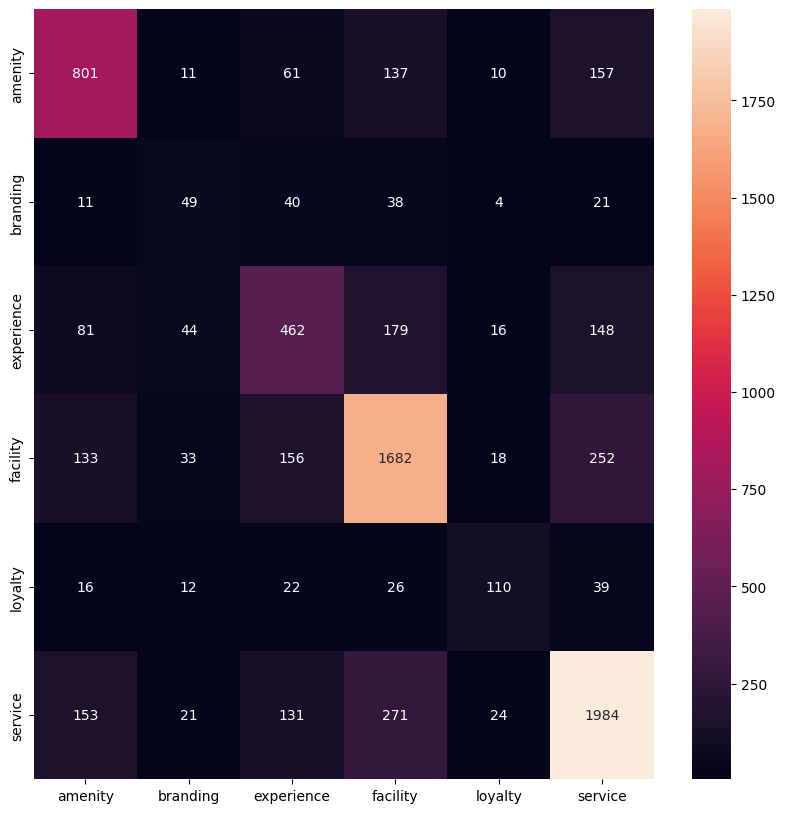

In [8]:
# Report Result
from IPython.display import display

############### Aspect term Report ####################
print('ASPECT TERM STATEMENT: \n')
print(f'Classification Report:\n {classification_report(results["Aspect"][0], results["Aspect"][1])}')
print()
print(f'Confusion Matrix: \n')
plt.figure(figsize=(10, 10))
list_aspect = ['amenity', 'branding', 'experience', 'facility', 'loyalty', 'service']
display(sns.heatmap(confusion_matrix(results["Aspect"][0], results["Aspect"][1]), annot=True, fmt='g', yticklabels = list_aspect, xticklabels = list_aspect))


SENTIMENT STATEMENT: 

Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.70      0.71      1066
     neutral       0.36      0.33      0.35       348
    positive       0.94      0.95      0.94      5939

    accuracy                           0.88      7353
   macro avg       0.67      0.66      0.66      7353
weighted avg       0.88      0.88      0.88      7353


Confusion Matrix: 



<Axes: >

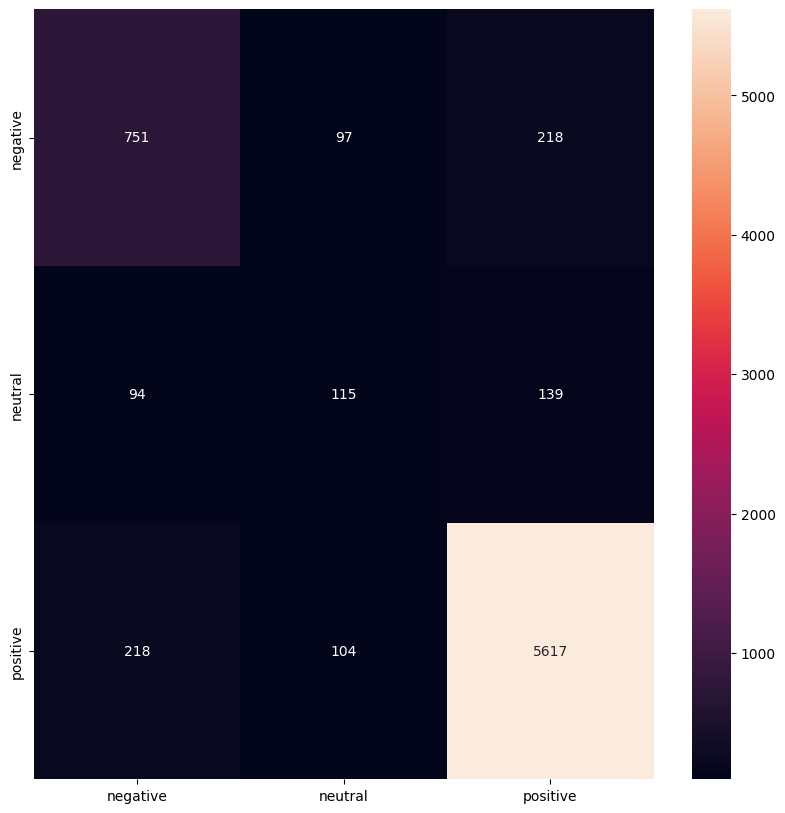

In [9]:
############### Sentiment Report ####################
print('SENTIMENT STATEMENT: \n')
print(f'Classification Report:\n {classification_report(results["Sentiment"][0], results["Sentiment"][1])}')
print()
print(f'Confusion Matrix: \n')
plt.figure(figsize=(10, 10))
list_sentiment = ['negative', 'neutral', 'positive']
display(sns.heatmap(confusion_matrix(results["Sentiment"][0], results["Sentiment"][1]), annot=True, fmt='g', yticklabels = list_sentiment, xticklabels = list_sentiment))

In [ ]:
# !python main.py --task tasd \
#             --dataset new_Data \
#             --model_name_or_path t5-base \
#             --paradigm extraction \
#             --n_gpu 0 \
#             --do_train \
#             --do_direct_eval \
#             --train_batch_size 16 \
#             --gradient_accumulation_steps 2 \
#             --eval_batch_size 16 \
#             --learning_rate 3e-4 \
#             --num_train_epochs 20

In [ ]:
# # zip file
# import shutil
# shutil.make_archive('/content/output', 'zip', '/content/AISIA-hotel/outputs')

In [ ]:
# import pandas as pd

# df = pd.read_csv('/content/predict_file.txt')
# df.head()

In [ ]:
# import json
# import pandas as pd
# with open('/content/predict_file.txt') as f:
#   string = f.readlines()
#   col1, col2 = [], []
#   for s in string:
#     c1, c2 = s.split(',', 1)
#     col1.append(c1)
#     col2.append(c2)

# df = pd.DataFrame({
#     'id_user': col1,
#     'text': col2
# })

In [ ]:
# df.head()

In [ ]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(df, test_size = 0.3, random_state=0)
# train, valid = train_test_split(train, test_size = 0.3, random_state=0)

In [ ]:

# train.to_csv('/content/predict1.txt')
# valid.to_csv('/content/predict2.txt.')
# test.to_csv('/content/predict3.txt')